--- Processing Dataset: FD004 ---

Training CNN on FD004...


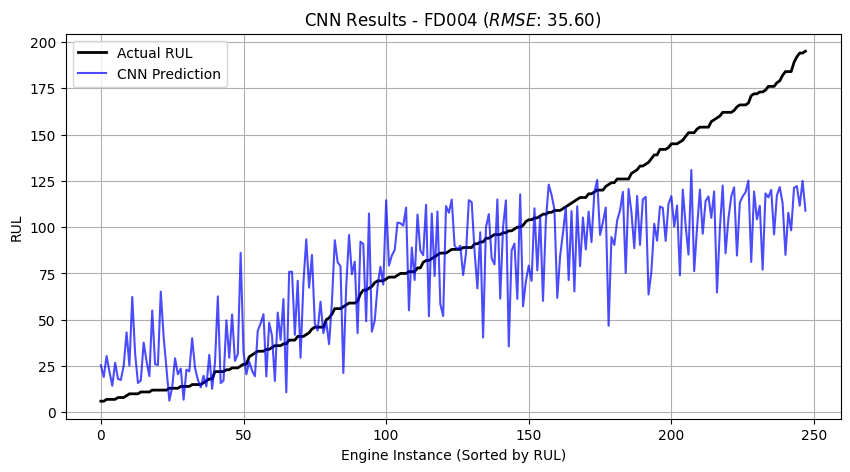


Training GRU on FD004...


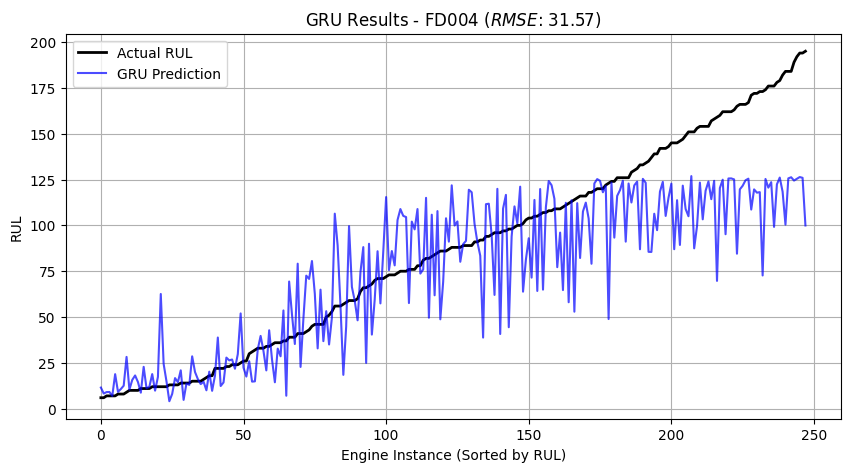


Training LSTM on FD004...


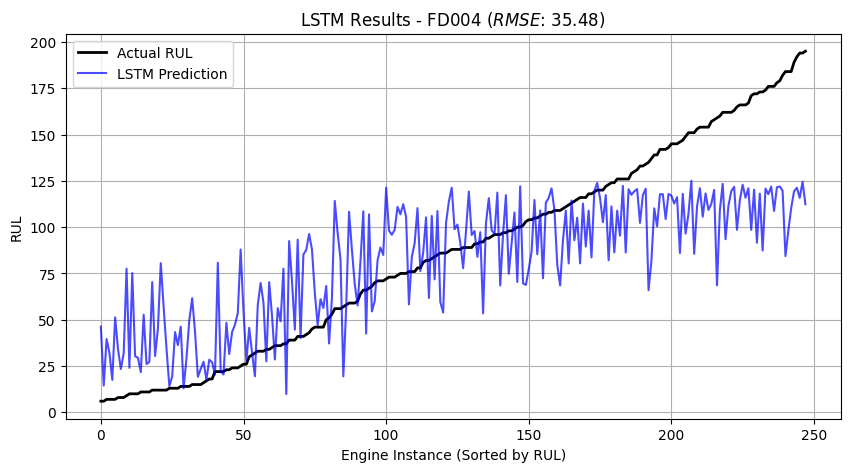


Training Stacked_LSTM on FD004...


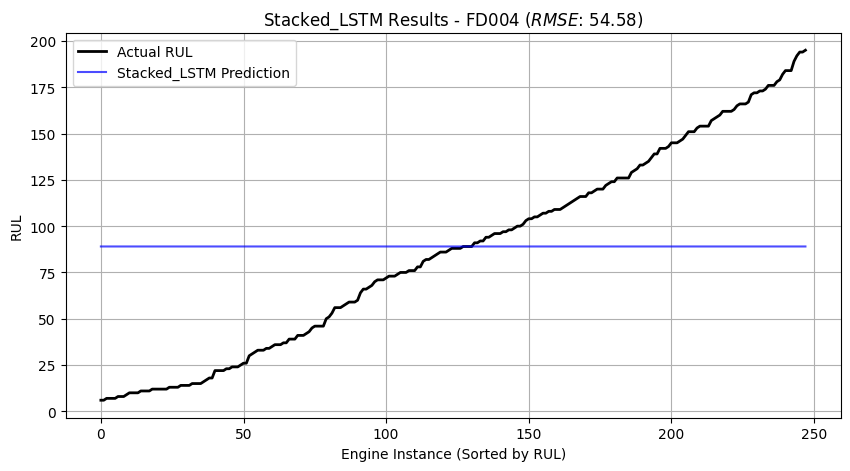


Training Bi_LSTM on FD004...


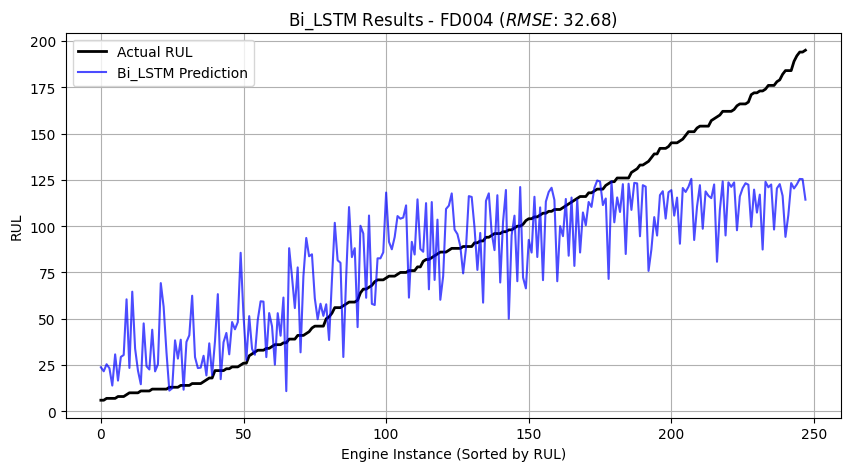


Training CNN_LSTM on FD004...


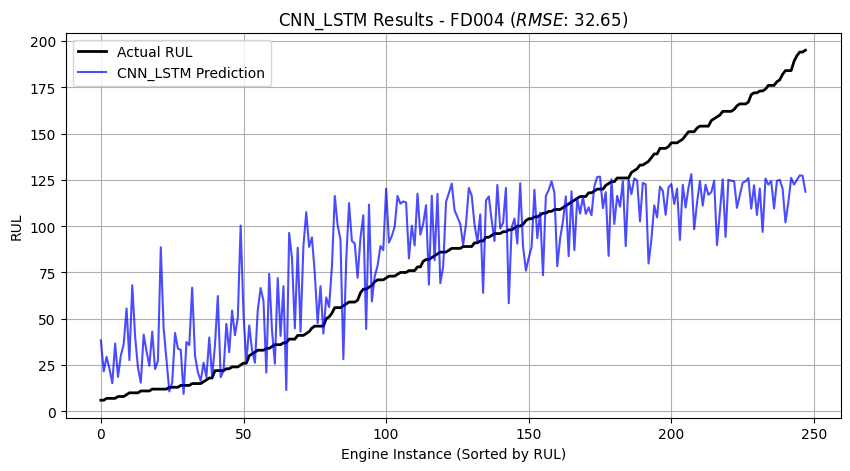


 FINAL PERFORMANCE SUMMARY - FD004
       Model         MSE      RMSE        R2
         CNN 1267.019409 35.595216  0.573802
         GRU  996.847046 31.572885  0.664682
        LSTM 1258.771240 35.479166  0.576577
Stacked_LSTM 2978.944580 54.579709 -0.002052
     Bi_LSTM 1067.853271 32.678024  0.640797
    CNN_LSTM 1066.130615 32.651656  0.641377

Winner: GRU (Lowest $RMSE$)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional, Flatten, TimeDistributed
from google.colab import files # For downloading to laptop

warnings.filterwarnings('ignore')

# 1. SETUP & DATA LOADING
DATASET_ID = 'FD004'
# Ensure the path matches your Google Drive or local setup
PATH = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

print(f"--- Processing Dataset: {DATASET_ID} ---")
df_train = pd.read_csv('/content/train_FD004.txt', sep='\s+', header=None, names=col_names)
df_test = pd.read_csv('/content/test_FD004.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('/content/RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])

# 2. PREPROCESSING FUNCTIONS (WITH PADDING FOR SHORT SEQUENCES)
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length - 1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul - 1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    # Padding logic for units shorter than the window
    if len(input_data) < window_length:
        padding_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((padding_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (padding_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(batch * shift):(batch * shift + window_length), :]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch * shift, batch * shift + window_length
            output_data[batch, :, :] = input_data[start:end, :]
            output_targets[batch] = target_data[end - 1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        padding_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((padding_len, 0), (0, 0)), mode='constant')
    max_batches = int(np.floor((len(test_data_unit) - window_length) / shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_data = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_data, num_windows

# 3. FEATURE ENGINEERING & SCALING
# Auto-detect and drop constant columns (sensors with no variance)
drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_cols))
test_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_cols))
num_features = train_scaled.shape[1]

window_length, shift, early_rul = 30, 1, 125

# Prepare Training Sequences
X_train_list, Y_train_list = [], []
for unit in df_train['unit_number'].unique():
    unit_data = train_scaled[df_train['unit_number'] == unit]
    unit_target = process_targets(len(unit_data), early_rul)
    x, y = process_input_data_with_targets(unit_data, unit_target, window_length, shift)
    X_train_list.append(x); Y_train_list.append(y)

X_train, Y_train = np.concatenate(X_train_list), np.concatenate(Y_train_list)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Prepare Test Sequences
X_test_list, test_window_counts = [], []
for unit in df_test['unit_number'].unique():
    unit_data = test_scaled[df_test['unit_number'] == unit]
    x, count = process_test_data(unit_data, window_length, shift, num_test_windows=5)
    X_test_list.append(x); test_window_counts.append(count)

X_test_final = np.concatenate(X_test_list)
Y_test_actual = y_test.values.flatten()

# 4. MODEL ARCHITECTURES
def get_all_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "GRU": Sequential([
            layers.GRU(128, input_shape=input_shape, return_sequences=True),
            layers.GRU(64),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Stacked_LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape, return_sequences=True),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Bi_LSTM": Sequential([
            layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=input_shape),
            layers.Bidirectional(layers.LSTM(64)),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "CNN_LSTM": Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

# 5. TRAINING, EVALUATION & INDIVIDUAL PLOTS
models = get_all_models((window_length, num_features))
results_summary = []
sort_idx = np.argsort(Y_test_actual)

for name, model in models.items():
    print(f"\nTraining {name} on {DATASET_ID}...")
    model.compile(optimizer='adam', loss='mse')
    # Increased epochs/batch_size slightly for FD004 due to larger dataset size
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=256, verbose=0)

    # Inference
    raw_preds = model.predict(X_test_final, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_window_counts)[:-1])
    engine_preds = np.array([np.mean(p) for p in preds_split])

    # Metrics
    mse = mean_squared_error(Y_test_actual, engine_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test_actual, engine_preds)
    results_summary.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Obj': model})

    # INDIVIDUAL PLOT
    plt.figure(figsize=(10, 5))
    plt.plot(Y_test_actual[sort_idx], color='black', label='Actual RUL', linewidth=2)
    plt.plot(engine_preds[sort_idx], color='blue', label=f'{name} Prediction', alpha=0.7)
    plt.title(f"{name} Results - {DATASET_ID} ($RMSE$: {rmse:.2f})")
    plt.xlabel("Engine Instance (Sorted by RUL)"); plt.ylabel("RUL")
    plt.legend(); plt.grid(True); plt.show()

# 6. PERFORMANCE SUMMARY
df_results = pd.DataFrame(results_summary)
print("\n" + "="*60)
print(f" FINAL PERFORMANCE SUMMARY - {DATASET_ID}")
print("="*60)
print(df_results[['Model', 'MSE', 'RMSE', 'R2']].to_string(index=False))

# 7. EXPORT & DOWNLOAD BEST MODEL
best_model_idx = df_results['RMSE'].idxmin()
best_model_name = df_results.loc[best_model_idx, 'Model']
export_filename = f"{DATASET_ID}model.h5"

df_results.loc[best_model_idx, 'Obj'].save(export_filename)
print(f"\nWinner: {best_model_name} (Lowest $RMSE$)")
print(f"Downloading {export_filename} to your laptop...")

# Trigger browser download
files.download(export_filename)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib  # Added for scaler export
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from google.colab import files

warnings.filterwarnings('ignore')

# 1. SETUP & DATA LOADING
DATASET_ID = 'FD004'
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

# Load raw files
df_train = pd.read_csv('/content/train_FD004.txt', sep='\s+', header=None, names=col_names)
df_test = pd.read_csv('/content/test_FD004.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('/content/RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])

# 2. PREPROCESSING FUNCTIONS
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length - 1, -1, -1)
    return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul - 1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    if len(input_data) < window_length:
        padding_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((padding_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (padding_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(batch * shift):(batch * shift + window_length), :]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch * shift, batch * shift + window_length
            output_data[batch, :, :] = input_data[start:end, :]
            output_targets[batch] = target_data[end - 1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        pad_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((pad_len, 0), (0, 0)), mode='constant')
    max_batches = int(np.floor((len(test_data_unit) - window_length) / shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_data = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_data, num_windows

# 3. FEATURE ENGINEERING & SCALING
drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_cols))
test_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_cols))

# --- SAVE SCALER AS PKL ---
scaler_filename = f"scaler_{DATASET_ID}.pkl"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved locally as {scaler_filename}")

num_features = train_scaled.shape[1]
window_length, shift, early_rul = 30, 1, 125

# Prepare Training Sequences
X_train_list, Y_train_list = [], []
for unit in df_train['unit_number'].unique():
    unit_data = train_scaled[df_train['unit_number'] == unit]
    unit_target = process_targets(len(unit_data), early_rul)
    x, y = process_input_data_with_targets(unit_data, unit_target, window_length, shift)
    X_train_list.append(x); Y_train_list.append(y)

X_train = np.concatenate(X_train_list)
Y_train = np.concatenate(Y_train_list)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Prepare Test Sequences
X_test_list, test_window_counts = [], []
for unit in df_test['unit_number'].unique():
    unit_data = test_scaled[df_test['unit_number'] == unit]
    x, count = process_test_data(unit_data, window_length, shift, num_test_windows=5)
    X_test_list.append(x); test_window_counts.append(count)

X_test_final = np.concatenate(X_test_list)
Y_test_actual = y_test.values.flatten()

# 4. MODEL ARCHITECTURES
def get_all_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ]),
        "Bi_LSTM": Sequential([
            layers.Bidirectional(layers.LSTM(64), input_shape=input_shape),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

# 5. TRAINING & EVALUATION
models = get_all_models((window_length, num_features))
results_summary = []
sort_idx = np.argsort(Y_test_actual)



for name, model in models.items():
    print(f"\nTraining {name} on {DATASET_ID}...")
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=15, batch_size=256, verbose=0)

    # Inference
    raw_preds = model.predict(X_test_final, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_window_counts)[:-1])
    engine_preds = np.array([np.mean(p) for p in preds_split])

    # Metrics
    rmse = np.sqrt(mean_squared_error(Y_test_actual, engine_preds))
    results_summary.append({'Model': name, 'RMSE': rmse, 'Obj': model})

    # Individual Plot
    plt.figure(figsize=(10, 4))
    plt.plot(Y_test_actual[sort_idx], color='black', label='Actual RUL')
    plt.plot(engine_preds[sort_idx], color='red', label=f'{name} Pred', alpha=0.7)
    plt.title(f"{name} Results - {DATASET_ID} (RMSE: {rmse:.2f})")
    plt.legend(); plt.show()

# 6. EXPORT & DOWNLOAD
df_results = pd.DataFrame(results_summary)
best_model_idx = df_results['RMSE'].idxmin()
best_model_name = df_results.loc[best_model_idx, 'Model']
export_filename = f"{DATASET_ID}model.h5"

# Save Model
df_results.loc[best_model_idx, 'Obj'].save(export_filename)

print(f"\nWinner: {best_model_name}. Downloading model and scaler...")

# --- TRIGGER DOWNLOADS ---
files.download(export_filename)
files.download(scaler_filename)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2168084316.py:25: SyntaxWarning: invalid escape sequence '\s'
  df_train = pd.read_csv('/content/train_FD004.txt', sep='\s+', header=None, names=col_names)
/tmp/ipython-input-2168084316.py:26: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv('/content/test_FD004.txt', sep='\s+', header=None, names=col_names)
/tmp/ipython-input-2168084316.py:27: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd.read_csv('/content/RUL_FD004.txt', sep='\s+', header=None, names=['RUL'])


Scaler saved locally as scaler_FD004.pkl

Training CNN on FD004...
